In [128]:
import pyspark as ps
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("df case study") \
            .getOrCreate()

#tweets_df = spark.read.json('./work/french_tweets.json').sample(False, 0.5)
tweets_df = spark.read.json('./work/french_tweets.json')

In [116]:
tweets_df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_

#### Insight: 
- This schema is big and complicated. We identified how to access values in the nested columns for favorite_count, retweet_count, etc. It was NOT obvious after the first look at the schema with some misleading column names (highlighting the hints about the original data being messy)

In [129]:
tweets_df.createOrReplaceTempView('french_tweets')

In [130]:
preview = spark.sql('''
                            SELECT text,
                            CASE WHEN text like '%le pen%macron%' 
                                    OR text like '%macron%le pen%'
                                    OR text like '%MLP%macron%'
                                    OR text like '%macron%MLP%'
                                    OR text like '%Le Pen%Macron'
                                    OR text like '%Macron%Le Pen%' 
                                    THEN 'BOTH'
                                WHEN text like '%macron%' 
                                    OR text like '%Macron%' THEN 'Macron'
                                WHEN text like '%le pen%' 
                                    OR text like '%Le pen%' 
                                    OR text like '%Le Pen%' 
                                    OR text like '%MLP%'
                                    OR text like '%mlp%'
                                    OR text like '%lepen%'
                                    OR text like '%Lepen%'
                                    THEN 'Le Pen'
                                ELSE 'none'
                                END mention
                            FROM french_tweets
                            ''')

In [ ]:
preview.show(20)

#### Insights:
- We had to use case-when statement for the combined "BOTH" mentions FIRST, otherwise it would match the criteria for one of the other statements.
- Opportunity to improve: there are probably ways to clean up the regex by making it case-insensitive.

In [131]:
import pandas as pd

In [176]:
pan_preview = preview.toPandas()
pan_preview

,text,mention
0,Je comprends pas trop la fin de 13 reasons why 😓,none
1,@julesbl99 travailles au lieu de raconter ta vie,none
2,@lecho_fr @lasaucelleoff J'espère faire mieux ...,none
3,"362 jours par an je suis adorable, aujourd'hui...",none
4,@julia71903850 Отличная реклама!,none
...,...,...
77441,♉️ https://t.co/MQARCGRedt,none
77442,4 questions fortes à l'initiative de la chaire...,none
77443,@C8TV @TPMP @EnoraMofficiel ❤️🇧🇪🚀 https://t.co...,none
77444,ptdr jui a lens,none


#### Insights: 
- The overwhelming majority of tweets did not mention either political candidate. Isolating only the tweets that mentioned the political candiates helped us focus in on the question: who was mentioned more?
- Eliminating tweets where the candidates were not mentioned also helped improve the scale of our graph and clean up visuals. 

In [133]:
filtered_pan_preview = pan_preview[pan_preview['mention'] != 'none']

In [140]:
import matplotlib.pyplot as plt

In [167]:
x_labels = ['Macron', 'Le Pen', 'BOTH']

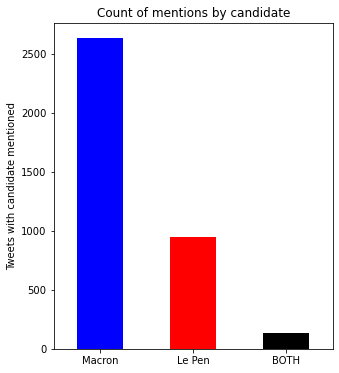

In [173]:
fig, ax = plt.subplots(figsize=(5,6))

ax = filtered_pan_preview['mention'].value_counts().plot(kind='bar', color=['blue', 'red', 'black'])
ax.set_title('Count of mentions by candidate')
ax.set_ylabel('Tweets with candidate mentioned')
ax.set_xticklabels(labels = x_labels , rotation=0, ha='center')

plt.show()


#### Insights: 
- Wow, did Macron really receive that many more mentions? We went back and re-checked our regex and found out:
le pen's twitter handle does not have the words "lepen" or "le_pen" in it, it is "@MLP_officiel", so we updated our regex to capture the string "MLP"...

- But that didn't change our results much. We decided to go to the real world for a sanity check and found that Macron not only handily won the election, but was much more popular in terms of twitter followers and google searches. It turns out the dataset is a good representation of reality: more people are talking about Macron, by a wide margin:  

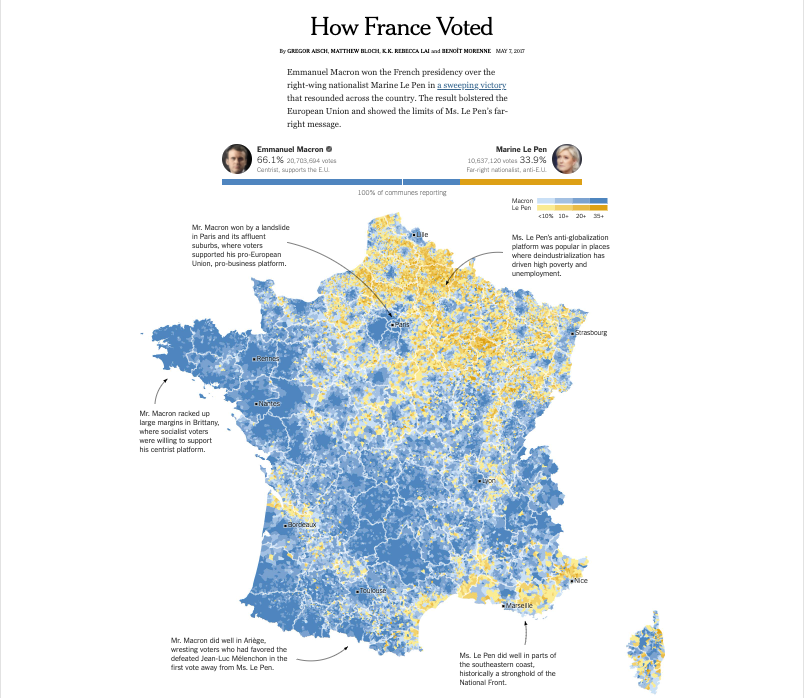

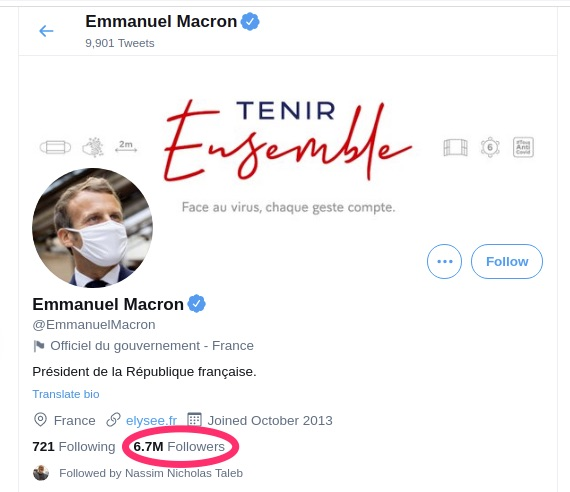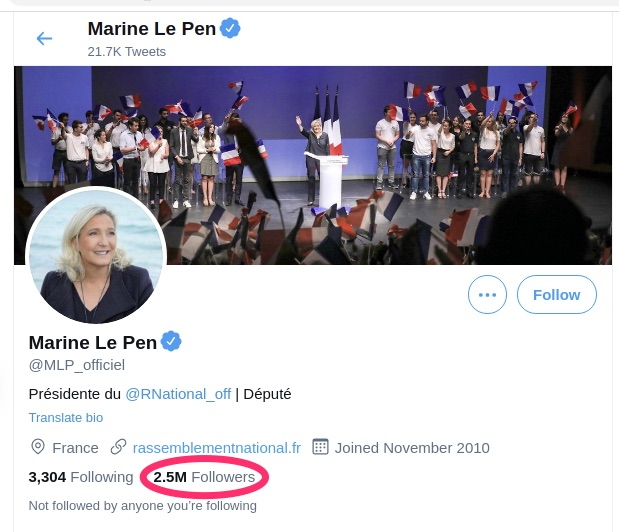 

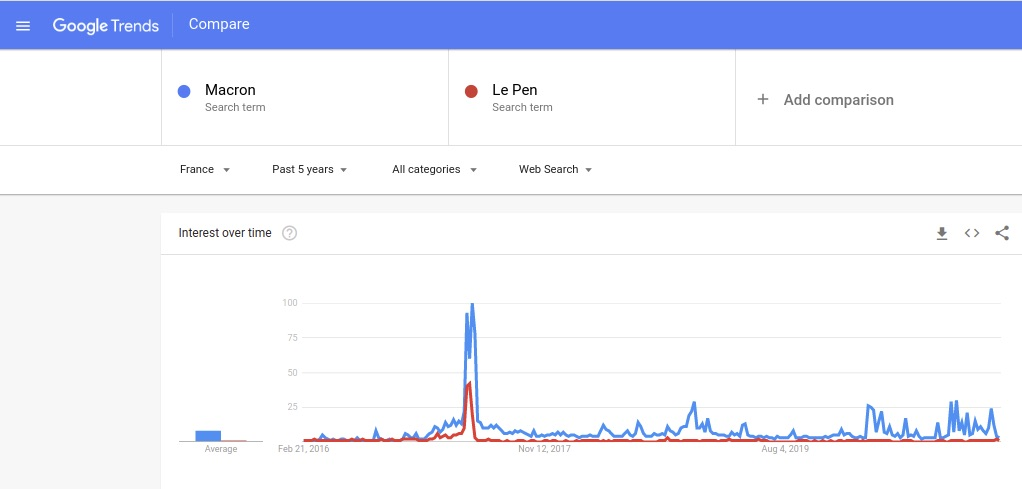

### Part 2

#### Exploring the effect of favorites and retweets:

In [186]:
preview2 = spark.sql('''
                        	SELECT  text, quoted_status.retweet_count, quoted_status.favorite_count,
                        	CASE WHEN text like '%le pen%macron%'
                                	OR text like '%macron%le pen%'
                                	OR text like '%MLP%macron%'
                                	OR text like '%macron%MLP%'
                                	OR text like '%Le Pen%Macron'
                                	OR text like '%Macron%Le Pen%'
                                	THEN 'BOTH'
                            	WHEN text like '%macron%'
                                	OR text like '%Macron%' THEN 'Macron'
                            	WHEN text like '%le pen%'
                                	OR text like '%Le pen%'
                                	OR text like '%Le Pen%'
                                	OR text like '%MLP%'
                                	OR text like '%mlp%'
                                	OR text like '%lepen%'
                                	OR text like '%Lepen%'
                                	THEN 'Le Pen'
                            	ELSE 'none'
                            	END mention
                        	FROM french_tweets
                        	WHERE quoted_status.retweet_count > 0
                       	 
                        	''')


In [187]:
mentions = preview2.toPandas()
impressions = mentions[mentions['mention']!='none'].copy()
impressions['trend_score'] = impressions['retweet_count']*impressions['favorite_count']
election = impressions.groupby('mention')
imp_sum = election.sum()
imp_sum



,retweet_count,favorite_count,trend_score
mention,,,
BOTH,934,920,261226
Le Pen,126268,81185,2257186667
Macron,102003,79454,163231236


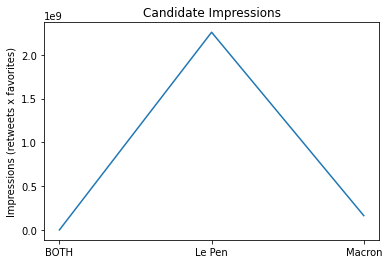

In [188]:
fig, ax = plt.subplots()
ax.plot(imp_sum.index, imp_sum.trend_score)
ax.set_ylabel('Impressions (retweets x favorites)')
ax.set_title('Candidate Impressions');